## <font color='blue'> ASTR 21100</font>

## <font color='blue'> Homework Assignment 4</font>
    
 
## <font color='blue'> 35 points</font>
   
### <font color='blue'> Distributed: Friday, January 31</font>

### <font color='blue'> Due: Friday, February 7, 10pm</font>

<center>
<img width=300 src="https://static.scientificamerican.com/blogs/assets/guest-blog/File/chart.png?w=1200"></img>
</center>

### <font color='blue'>Introduction</font> 

In this assignment you will implement your own ensemble sample (either DE MCMC or GW10) and will estimate dimensionless mean density of matter, $\Omega_{\rm m0}$, and dark energy, $\Omega_\Lambda$. Results of this analysis should show statistical evidence that the dark energy density is significantly different from  zero. This [dark energy](https://blogs.scientificamerican.com/guest-blog/no-astronomers-haven-t-decided-dark-energy-is-nonexistent/) has very peculiar properties (it acts as anti-gravity) and accelerates expansion of our Universe. <a href="https://www.nobelprize.org/prizes/physics/2011/press-release/">The 2011 Nobel Prize in Physics</a> was awarded for this type of analysis first published by two competing teams in 1998. 

Detailed description of the method of using supernovae type Ia to constrain the mean density of matter and dark energy in our Universe is described in [Section 9.2](https://astro.uchicago.edu/~andrey/classes/a211w25/html/appendix/astro.html#supernovae-type-ia-as-standardizable-candles) and [Section 9.3](https://astro.uchicago.edu/~andrey/classes/a211w25/html/appendix/astro.html#constraining-mean-density-of-matter-and-dark-energy-with-supernova-type-ia) of the notes notebook. Please review these sections if you want to understand what is behind the model you will use in this assignment better. 

Key equations needed to implement exercises below are reproduced in this notebook. This requires a combination of the computational methods we've been discussing in the course and Bayesian statistics. Links to relevan parts of the notes describing statistical background are provided, but do reach out if something is not clear or you are not certain you understand the stat aspects of this assignment. 

There are 4 exercises described below, but ***you should choose exercise 2 OR 3*** (i.e., implement either DE MCMC or the Goodman & Weare 2010 affine-invariant algorithm). 

The exercises in this assignment are related because their results are combined to achieve a specific goal: to estimate the mean density of matter and dark energy in the Universe. 
A reasonable strategy for completing this assignment is to implement exercise 1 using SciPy's `differential_evolution` and exercise 4 using `emcee` package. You can then focus on exercise 2 or 3 and after you complete and test your MCMC implementation, you can redo calculations in exercise 4 with your function. 

***Note:*** If you do not complete MCMC function implementation in exercise 2 or 3, you can do exercise 4 using the [emcee]() package, which you can install following instructions [here](https://emcee.readthedocs.io/en/stable/user/install/). 

Example of how to use this package is provided below. 

***Note:*** If you are done with the exercises and want more challenge, consider optimizing MCMC functions in exercise 2 or 3 to remove the loop over members/walkers. You can also try to implement a parallel version of the MCMC sampler that splits work on multiple processors. If you are interested in these options for possible extra-credit, please contact instructor. 

Import NumPy and Matplotlib and set Matplotlib defaults to produce nicer plots + a function to plot 2d histograms that will be used in this exercise. 

In [26]:
import numpy as np 

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import scipy.optimize as opt

# the following code make plots look better
def plot_prettier(dpi=150, fontsize=11, usetex=False): 
    '''
    Make plots look nicer compared to Matplotlib defaults
    Parameters: 
        dpi - int, "dots per inch" - controls resolution of PNG images that are produced
                by Matplotlib
        fontsize - int, font size to use overall
        usetex - bool, whether to use LaTeX to render fonds of axes labels 
                use False if you don't have LaTeX installed on your system
    '''
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    if usetex:
        plt.rc('text', usetex=usetex)
    else:
        plt.rcParams['mathtext.fontset'] = 'cm'
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
        
def conf_interval(x, pdf, conf_level):
    return np.sum(pdf[pdf > x])-conf_level

def plot_2d_dist(x,y, xlim, ylim, nxbins, nybins, figsize=(5,5), plot_samples=False, 
                cmin=1.e-4, cmax=1.0, smooth=None, xpmax=None, ypmax=None, 
                log=False, weights=None, xlabel='x', ylabel='y', 
                clevs=None, fig_setup=None, savefig=None):
    """
    construct and plot a binned, 2d distribution in the x-y plane 
    using nxbins and nybins in x- and y- direction, respectively
    
    log = specifies whether logged quantities are passed to be plotted on log-scale outside this routine
    """
    if fig_setup is None:
        fig, ax = plt.subplots(figsize=figsize)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
    else:
        ax = fig_setup
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim); ax.set_ylim(ylim)

    if xlim[1] < 0.: ax.invert_xaxis()

    if weights is None: weights = np.ones_like(x)
    H, xbins, ybins = np.histogram2d(x, y, weights=weights, 
                                     bins=(np.linspace(xlim[0], xlim[1], nxbins),
                                           np.linspace(ylim[0], ylim[1], nybins)))
    
    H = np.rot90(H); 
    H = np.flipud(H); 
             
    X,Y = np.meshgrid(xbins[:-1],ybins[:-1]) 

    if smooth != None:
        from scipy.signal import wiener
        H = wiener(H, mysize=smooth)
        
    H = H/np.sum(H)        
    Hmask = np.ma.masked_where(H==0,H)
    
    if log:
        X = np.power(10.,X); Y = np.power(10.,Y)

    pcol = ax.pcolormesh(X, Y, (Hmask),  cmap=plt.cm.BuPu, norm = LogNorm(), linewidth=0., 
                         rasterized=True, shading='nearest', antialiased=True)
    pcol.set_edgecolor('face')
    
    # plot contours if contour levels are specified in clevs 
    if clevs is not None:
        lvls = []
        for cld in clevs:  
            sig = opt.brentq( conf_interval, 0., 1., args=(H,cld) )   
            lvls.append(sig)
        
        ax.contour(X, Y, H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = sorted(lvls), 
                norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])
    if plot_samples:
        ax.scatter(x, y, s=0.051, c='orangered')
    if xpmax is not None:
        ax.scatter(xpmax, ypmax, marker='x', c='orangered', s=20)
    if savefig:
        plt.savefig(savefig, bbox_inches='tight')
    if fig_setup is None:
        plt.show()
    return


plot_prettier()

### <font color='blue'>Supernova type Ia data</font> 

The code snippet below reads data from the study of <a href="https://ui.adsabs.harvard.edu/abs/2014A%26A...568A..22B/abstract">Betoule et al. (2014)</a>, which was downloaded <a href="http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html">here</a>. The function uses numpy loadtxt function, which allows to read well formatted columns of data in the ASCII format easily. 
    
After reading numpy array <tt>zsn</tt> contains redshifts of 740 supernovae, while arrays <tt>msn</tt>, $m$, and <tt>emsn</tt> contain measured apparent magnitudes and their uncertainties. Parameters <tt>x1</tt>, <tt>ex1</tt>, <tt>csn</tt>, <tt>ecsn</tt> are the color and stretch parameters of the supernovae in their sample and their uncertainties.

In [27]:
#zsn, msn, emsn are redshift of SNia, its apparent B-band magnitude, and emB is its error
# x1 and ex1 are stretch parameter measured for each SN and its uncertainty
# csn and ecsn are color parameter and its uncertainty
zsn, msn, emsn, x1, ex1, csn, ecsn = np.loadtxt('https://astro.uchicago.edu/~andrey/classes/a211/data/jla_lcparams.txt', 
                                               usecols=(1, 4, 5, 6, 7, 8, 9), unpack=True)

print("read sample of %d supernovae..."%(np.size(zsn)))

read sample of 740 supernovae...


### <font color='blue'>Exercise 1 (8 points): Implementing posterior pdf with uniform prior pdfs and finding parameter values that maximizes likelihood of supernovae type Ia data given model parameters</font>

**Task 1a (6 points).** Implement a function to compute the natural logarithm of the posterior pdf. This is a sum of the $\ln$ of the likelihood and $\ln $ of the prior (see [Section 9.17.5](https://astro.uchicago.edu/~andrey/classes/a211w25/html/appendix/stat.html#bayesian-statistical-analysis)). 

The likelihood pdf of the supernova data given the model parameters using the expression derived in [Sections 9.17.14](https://astro.uchicago.edu/~andrey/classes/a211w25/html/appendix/stat.html#the-likelihood-pdf-of-data-given-a-model) and [Section 9.3](https://astro.uchicago.edu/~andrey/classes/a211w25/html/appendix/astro.html#constraining-mean-density-of-matter-and-dark-energy-with-supernova-type-ia) of the notes:

$$\ln L(\mathbf{y}\vert\mathbf{x}) = -\frac{1}{2}\,\sum\limits_{i=0}^{N_{\rm SN}-1}\frac{\Delta m_i^2}{\sigma_{\Delta m,i}^2}-\frac{1}{2}\sum\limits_{i=0}^{N_{\rm SN}-1}\ln(2\pi\sigma_{\Delta m,i}^2)$$

where $\Delta m$ is the difference between observational measurement of magnitude, $m_{\rm obs}$, and model prediction $m_{\rm pred}(z,\Omega_{\rm m0},\Omega_\Lambda)$, where $z$ is the observed redshift of the supernova $i$ then can be written as 
$$
\Delta m_i=m_{\rm i, obs} - m_{\rm pred}(z_i,\Omega_{\rm m0},\Omega_\Lambda)= m_{i, \rm obs} - 5\log_{10}d_L(z_i,\Omega_{\rm m0},\Omega_\Lambda) - M_0 +  \alpha x_{1,i} - \beta c_i - 25,$$ 

where $d_L$ is the luminosity distance, computed as in HW 3 and $x_1$ and $c$ are the "stretch" and "color" parameters measured for each supernova and are read as part of the data by the code above. You can use function `d_l_astropy` below to compute $d_L$. Note that this function will return an array of distances for an array of input redshifts. The calculation of $\Delta m$ can thus be done in one line without using the loop over supernovae.  

and $\sigma_{\Delta m,i}^2$ is total uncertainty of the observational estimate of the distance modulus that accounts for uncertainties in $m_B$, $x_1$, and $c$, which by rules of error propagation is: 

$$\sigma_{\Delta m,i}^2 = \sigma_{m_{\rm i,obs}}^2 + \alpha^2\sigma_{x1}^2 + \beta^2\sigma_c^2,$$

which means that the error also depends on the two model parameters, $\alpha$ and $\beta$. 

The vector of parameters $\mathbf{x}$ in this problem thus contains 
5 parameters $\mathbf{x}=\{\Omega_{\rm m0},\Omega_\Lambda, M_0, \alpha,\beta\}$. That is you will be solving optimization problem and sampling from the posterior pdf in 5 dimensions. 

The function should pass arrays containing supernova data  via <tt>args</tt>.

Prior pdf should be uniform for the parameters with the limits of the pdf for each model parameter as follows: $\Omega_{\rm m0}: [0,1]$, $\Omega_{\rm \Lambda}: [0,1]$, $M_0: [-25,-15]$, $\alpha: [0, 0.3]$, $\beta: [0,5]$. Feel free to experiment with these ranges. Example of how uniform prior pdf can be implemented is given for the Bayesian inference of the linear model parameters in [Section 9.17.6](https://astro.uchicago.edu/~andrey/classes/a211w24/html/appendix/stat.html#specific-example-linear-model). 

**Task 1b. (2 points)** Test your function by  finding the values of the 5 parameters $\mathbf{x}=\{\Omega_{\rm m0},\Omega_\Lambda, M_0, \alpha,\beta\}$ that minimize this function using the differential evolution function you implemented in hw 4, or <a href="https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.differential_evolution.html"><tt>scipy.minimize.differential_evolution</tt></a> function. Print out the values. Note that the values of $\Omega_{\rm m0}$ and $\Omega_\Lambda$ should be close to (but not exactly equal) to the values currently determined by a combination of various observational constraints (see, e.g., last 2 lines in the Table 25.1 on p. 14 in [this paper](https://arxiv.org/pdf/2201.08666.pdf)): $\Omega_{\rm m0}\approx 0.3$ and $\Omega_\Lambda\approx 0.7$. 



**Task 1c (2 points)** Modify the $\chi^2$ function from ex 4 of hw 4 to account for the different calculation of $m_{\rm pred}$ and calculate and print the reduced $\chi^2$ value for the best fit model obtained in 1b. Remember that the number of parameters in this model is $N_{\rm param}=5$. 

$$\chi^2_{\rm red} = \frac{1}{N_{\rm SN}-N_{\rm param}}\sum\limits_{i=0}^{N_{\rm SN}-1}\frac{ (m_{i,\rm obs}-m_{\rm i,\rm pred})^2}{\sigma_{\Delta m_i}^2},$$

where

$$
\Delta m=m_{\rm obs} - m_{\rm pred} =m_{\rm obs} - M_0 - 5\log_{10}d_L(z,\Omega_{\rm m0},\Omega_\Lambda)+  \alpha x_1 - \beta c - 25.
$$

and 
$$\sigma_{\Delta m,i}^2 = \sigma_{m_B}^2 + \alpha^2\sigma_{x1}^2 + \beta^2\sigma_c^2,$$


In [28]:
from astropy.cosmology import LambdaCDM
import astropy.units as u

def d_l_astropy(z, H0, Om0, OmL, clight=2.99792e5):
    '''
    compute luminosity distance using AstroPy d_L function
    
    Parameters:
    
    z - float, or numpy array, redshift
    H0 - float, Hubble constant in km/s/Mpc
    Om0, OmL - floats, dimensionless matter and dark energy densities
    
    Returns:
    
        d_L - float, or numpy array, rescaled by c/H0 in Mpc 
    '''
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=OmL)
    
    return cosmo.luminosity_distance(z=z) / u.Mpc 

In [29]:
#problem 1a: 

def neg_log_posterior(x): #because we want to maximize log posterior
    #we can instead minimize negative log posterior
    om0 = x[0]
    oml = x[1]
    M0 = x[2]
    a = x[3]
    b = x[4]
    sigma2 = emsn**2 + (a**2*ex1**2) + (b**2*ecsn**2)
    array25 = np.ones(len(msn))*25
    arrayM0 = np.ones(len(msn))*M0
    mpred = arrayM0 + 5*np.log10(d_l_astropy(zsn, 70, om0, oml)) + array25 - a*x1 + b*csn
    difference2 = (msn - mpred)**2
    log_likelihood = -.5 * (np.sum(difference2/sigma2) + np.sum(np.log(2*np.pi*sigma2)))
    prior_om0 = 1/(1-0)
    prior_oml = 1/(1-0)
    prior_M0 = 1/(-15 - (-25))
    prior_a = 1/(.3 - 0)
    prior_b = 1/(5 - 0)
    total_prior = prior_om0*prior_oml*prior_M0*prior_a*prior_b
    log_prior = np.log(total_prior)
    log_posterior = -(log_likelihood + log_prior)
    return log_posterior
    
    

In [30]:
#now part 1b: testing using scipy minimize DE function

from time import time

from scipy.optimize import differential_evolution
# the total number of pop members will be popsize*5
popsize = 10

bounds = np.array([(0, 1), (0, 1), (-25, -15), 
                   (0, .3), (0, 5)])

s = 0.2
tstart = time()
res = differential_evolution(neg_log_posterior, bounds=bounds, mutation=[s, 1.], recombination=1., 
                               atol=1.e-8, tol=0., strategy='rand1bin',
                               popsize=popsize, polish=False)
print(f"completed in {(time() - tstart):.3g} sec")
print("found minimum at:", res.x)
print(f"in {res.nfev:d} function evaluations")
print(40*'-')
#the parameters i get from this do seem to be very reasonable,
#and slightly different than the expected values 

completed in 4.62 sec
found minimum at: [  0.25752373   0.63500957 -19.07998708   0.11942748   2.5793553 ]
in 5300 function evaluations
----------------------------------------


In [31]:
def new_chi_squared(x): 
    om0 = x[0]
    oml = x[1]
    M0 = x[2]
    a = x[3]
    b = x[4]
    sigma2 = emsn**2 + (a**2*ex1**2) + (b**2*ecsn**2)
    array25 = np.ones(len(msn))*25
    arrayM0 = np.ones(len(msn))*M0
    mpred = arrayM0 + 5*np.log10(d_l_astropy(zsn, 70, om0, oml)) + array25 - a*x1 + b*csn
    difference2 = (msn - mpred)**2
    chi2 = np.sum(difference2/sigma2)
    return chi2

x = [0.2575192, 0.63500065, -19.07998601, 0.11942746, 2.57935686]
chi2 = new_chi_squared(x)
reducedchi2 = chi2 / 735
print(reducedchi2)

0.9342337350451914


# <font color='blue'> Exercise 2: Implementing the Differential evolution MCMC algorithm  (15 points). </blue>
    
#### <font color='blue'>Task 2a (12 points).</blue>
Implement the Differential Evolution MCMC algorithm proposed by Ter Braak (2006) and described in [Section 7.5.14](https://astro.uchicago.edu/~andrey/classes/a211w24/html/mc/mcmc.html#differential-evolution-mcmc-de-mcmc) of the notes  in a Python function.
    
The overall structure of the function is similar to the differential evolution function you should have implemented in hw 4 and you can use your implementation or implementation in the solution that will be provided to you as a starting point. The difference is in the way that steps (mutation) are made and condition defining whether a step is accepted or rejected are different. The stopping criterion here, however, can be simple - for example, stop after a given number of steps is made. 
    

Below is the possible format of such function. 
    
    
    def mcmc_de(x0, logpdf = None, args = None, nsteps=10000):
        """
        MCMC sampler implementing the Goodman & Weare (2010) 
        affine-invariant algorithm 

        run for nminsteps and convergence specified by convergence_func is reached

        Parameters:
        ------------
        x - numpy array of floats of shape (nwalkers,ndim)
            containing initial x values of the chains
        logpdf - python function object
            ln(pdf) where pdf is the target pdf to sample
        args - tuple with arguments to pass logpdf functions (as logpdf(x, *args))
        nteps - int
            minimum number of MCMC steps (iterations) to make
    
        Returns:
        ---------
        chain - numpy array of shape (nwalkers*nsteps, ndim)
            x values of samples in the MCMC chains given that chain length is nsteps
        """


***Note:*** After you implement and test your version and complete the exercises, you can try to use numpy capabilities to optimize
the MCMC function so that there is only the loop making steps and there are no loops over walkers and dimensions. Feel free to ask for guidance. 

    
***Note:*** It can be convenient to define a class that implements MCMC sampler and methods associated with it (this is what is done in the <tt>emcee</tt> package). Once you are done with your function and the rest of the homework, I encourage you try this if you want to practice using classes in practice. Feel free to ask for guidance. 


In [32]:
def bounds_check(x, bounds):
    b = 0 
    if bounds is not None: 
        for i in range(len(x)):
            if bounds[i, 0] <= x[i] <= bounds[i, 1]:
                b+=0 
            else: 
                b += 1
    return b

def de_mcmc(x0, logpdf = None, *args, atol = 1e-6, nsteps = 10000, bounds = None):
    npop = np.shape(x0)[0]
    dim = np.shape(x0)[1]
    xnow = np.copy(x0)
    chain = np.zeros(shape = (npop, dim, nsteps))
    step = 0
    accept = 0
    while step < nsteps: 
        for i in range(npop):
            ir1 = np.random.randint(0, npop)
            ir2 = np.random.randint(0, npop)
            while ir2 == ir1: 
                ir2 = np.random.randint(0, npop)
            e_constant = np.random.uniform(-.001, .001)
            e = np.ones(len(xnow[i]))*e_constant 
            xtry = xnow[i] + 2.38 / np.sqrt(dim)*(xnow[ir1] - xnow[ir2])
            b = bounds_check(xtry, bounds)
            if b ==0:
                fnow = logpdf(xnow[i], *args)
                ftry = logpdf(xtry, *args)
                if ftry > fnow:
                    xnow[i] = xtry
                    accept += 1
                else:
                    u = np.random.uniform()
                    if np.log(u) < ftry - fnow:
                        xnow[i] = xtry
                        accept +=1
            chain[i, :, step] = xnow[i]
        step +=1
    return xnow, np.array(chain), accept/(nsteps*npop)

#### <font color='blue'> Task 2b (3 points)</font>

Test your implementation of the DE MCMC algorithm by sampling $\ln$ 2d Gaussian pdf using function <tt>lngauss_nd</tt> below. Plot resulting distributions of chain values for $\Omega_{\rm m0}$ and $\Omega_\Lambda$ along with the confidence contours that correspond to $1-$ and $2-\sigma$ of the Gaussian distribution and enclose $0.6827$ and $0.9545$ of the total samples using example below using <tt>plot_2d_dist</tt> function from <tt>codes/plotting.py</tt>. 

Example below shows such test using <tt>emcee</tt> package. 

In [33]:
def lngauss_nd(x, means, icov):
    """
    ln of N-dimensional unnormalized Gaussian pdf (neglecting the constant in front of exp)
    
    Parameters:
    -----------
    x - real 1d numpy vector of size ndim
        position of a sample in ndim-dimensional space
    means - real 1d numpy vector of size ndim
        mean values of the Gaussian in each coordinate
    icov - numpy array of floats of shape (ndim, ndim)
        inverse covariance matrix of the Gaussian
        
    Returns:
    --------
    
    a real number 
        ln(Gaussian)
    """
    diff = x - means
    
    return -0.5 * np.dot(diff.T, np.dot(icov,diff)) 

In [47]:
# define st deviations for the two dimension of the Gaussian and value of correlation coefficient
means = [0., 0.] # values of means of Gaussian pdf for 2 dimensions
s1, s2, r = 1.0, 1.0, 0.95

# covariance matrix of 2-dimensional Gaussian
cov = [[s1**2, r*s1*s2], [r*s1*s2, s2**2]]
# compute the inverse covariance matrix
icov = np.linalg.inv(cov)
args = [means, icov]

In [50]:
#problem 2b 

ndim, nwalkers, nsteps = 2, 50, 50000

# initialize walkers around best fit parameter values
p0 = 0.05 * np.random.normal(size=(nwalkers,ndim))
xnext,  chain, accept = de_mcmc(p0, lngauss_nd, *args, atol = 1e-6, nsteps = 50000)

x = chain[:,0, :].flatten()
y = chain[:,1, :].flatten()


/var/folders/m0/hlc6y73128n1wbz2yg_t5bh40000gn/T/ipykernel_7297/4239417626.py:95: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(X, Y, H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = sorted(lvls),


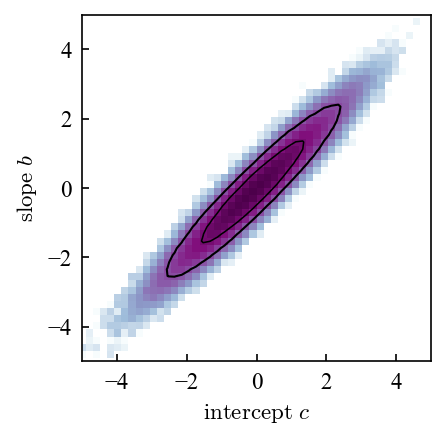

In [52]:
conflevs = [0.6827, 0.9545]


plot_2d_dist(x, y, xlim=[-5, 5], ylim =[-5,5], 
             nxbins=50, nybins=50, 
             clevs=conflevs, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

In [37]:
def clims(a):
    '''
    compute confidence limits given a given percentile a
    '''
    x1 = 0.5*(100.-a)
    return x1, a + x1

def chain_stats(x, param_name='x'):
    """
    print mean, median, and confidence intervals for samples for a chain of sampled values
    for a *single* parameter
    """
    xmed = np.median(x); xm = np.mean(x); xsd = np.std(x)
    a = 68.268; 
    x1, x2 = clims(a)
    xcfl11 = np.percentile(x,x1); xcfl12 = np.percentile(x,x2)
    a = 95.452
    x1, x2 = clims(a)
    xcfl21 = np.percentile(x,x1); xcfl22 = np.percentile(x,x2)
    dashedline = '-------'
    print('============ statistics for the {:s} ============'.format(param_name))
    print('mean, median = %.3f, %.3f, st.dev=%.4f'%(xm, xmed, xsd))
    print('68 perc interval = %.3f, %.3f'%(xcfl11, xcfl12))
    print('95 perc interval = %.3f, %.3f'%(xcfl21, xcfl22))


In [38]:
chain_stats(x, param_name='x')
chain_stats(y, param_name='y')

============ statistics for the x ============
mean, median = -0.011, -0.018, st.dev=0.9971
68 perc interval = -1.003, 0.991
95 perc interval = -1.998, 1.973
============ statistics for the y ============
mean, median = -0.011, -0.016, st.dev=0.9966
68 perc interval = -1.005, 0.989
95 perc interval = -2.003, 1.982


Note that we estimate mean for the parameters with uncertainty $0.07-0.09$ despite the fact that we have 50000 samples because effective number of independent samples here is only a few thousand due to correlations between neighboring samples. 

In [20]:
import emcee

ndim, nwalkers, nsteps = 2, 50, 50000

# initialize walkers around best fit parameter values
p0 = 0.05 * np.random.normal(size=(nwalkers,ndim))
   
# create an instance of the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim,  lngauss_nd, args=args)

# run for a given nsteps
tstart = time()
dummy = sampler.run_mcmc(p0, nsteps)
print(f'finished {nsteps:d} MCMC steps with emcee in {time()-tstart:.4} sec')

# get chain; its shape is shape is (nwalkers, nsteps, ndim)
chain = np.array(sampler.chain)

ModuleNotFoundError: No module named 'emcee'

### <font color='blue'> Exercise 3: Implementing the affine-invariant MCMC algorithm of Goodman & Weare (2010) and using it to sample the likelihood (15 points). </blue>
    
#### <font color='blue'>Task 3a (12 points).</font>

Implement the "affine-invariant" MCMC algorithm proposed by <a href="http://msp.org/camcos/2010/5-1/p04.xhtml">Goodman & Weare (2010, hereafter GW10)</a> and described in [Section 7.5.15](https://astro.uchicago.edu/~andrey/classes/a211w24/html/mc/mcmc.html#affine-invariant-ensemble-sampler-of-goodman-weare-2010) of the notes  in a Python function.
    
The overall structure of the function is similar to the differential evolution function you should have implemented in hw 4 and you can use your implementation or implementation in the solution that will be provided to you as a starting point. The difference is in the way that steps (mutation) are made and condition defining whether a step is accepted or rejected are different. The stopping criterion here, however, can be simple - for example, stop after a given number of steps is made. 
    

Below is the possible format of such function. 
    
    
    def mcmc_gw10(x0, logpdf = None, args = None, nsteps=10000):
        """
        MCMC sampler implementing the Goodman & Weare (2010) 
        affine-invariant algorithm 

        run for nminsteps and convergence specified by convergence_func is reached

        Parameters:
        ------------
        x - numpy array of floats of shape (nwalkers,ndim)
            containing initial x values of the chains
        logpdf - python function object
            ln(pdf) where pdf is the target pdf to sample
        args - tuple with arguments to pass logpdf functions (as logpdf(x, *args))
        nteps - int
            minimum number of MCMC steps (iterations) to make
    
        Returns:
        ---------
        chain - numpy array of shape (nwalkers*nsteps, ndim)
            x values of samples in the MCMC chains given that chain length is nsteps
        """

**Note:** The $z_r$ random numbers used in the GW10 algorithm can be sampled using the implementation of exercise 1 from HW 4 with $a=2$. If you did not complete this exercise, please consult hw04_solutions notebook. 
    
***Note:*** After you implement and test your version and complete the exercises, you can try to use numpy capabilities to optimize
the MCMC function so that there is only the loop making steps and there are no loops over walkers and dimensions. Feel free to ask for guidance. 


***Note:*** It can be convenient to defined a class that implements MCMC sampler and methods associated with it (this is what is done in the <tt>emcee</tt> package). Once you are done with your function and the rest of the homework, I encourage you try this if you want to practice using classes in practice. Guidance can be provided upon request. 


#### <font color='blue'> Task 3b (3 points)</font>

Test your implementation of the GW 10 MCMC algorithm by sampling $\ln$ 2d Gaussian pdf using function <tt>lngauss_nd</tt> below. Plot resulting distributions of chain values for $\Omega_{\rm m0}$ and $\Omega_\Lambda$ along with the confidence contours that correspond to $1-$ and $2-\sigma$ of the Gaussian distribution and enclose $0.6827$ and $0.9545$ of the total samples using example below using <tt>plot_2d_dist</tt> function from <tt>codes/plotting.py</tt>. 

Example in the exercise 2 above shows such test using the <tt>emcee</tt> package. 

### <font color='blue'> Exercise 4: using DE MCMC or GW 10 MCMC  to sample the likelihood (10 points). </font>

Use a function that defines the natural logarithm of the posterior pdf with uniform priors implemented in exercise 1 to generate as many samples of the posterior pdf as you can using the DE MCMC or GW 10 method you implemented in exercise 2 or 3. 

* Initialize positions of the member/walkers as to avoid burn-in in the MCMC sequence (hint: use results obtained in exercise 1). (1 point)

* Run MCMC sampling of the log of the posterior pdf implemented in exercise 1 to produce MCMC chains for all 5 model parameters. You can produce few thousand samples while you are testing, but present your final results with at least 10000 samples for your final statistical results below (5 points). 

* Make trace plots for every parameters and visually estimate the correlation time as the typical widths of peaks and valleys in the trace plot. Estimate (roughly) the number of independent samples in your chain and the fractional accuracy of the statistical measurements you can expect from the chains. (3 points)

* Plot resulting distributions of chain values for $\Omega_{\rm m0}$ and $\Omega_\Lambda$ along with the confidence contours that correspond to $1-$ and $2-\sigma$ similarly to the example of the Gaussian distribution and enclose $0.6827$ and $0.9545$ in exercise 3b above. Use examples above  (for example, function <tt>chain_stats</tt> to output statistics about $\Omega_{\rm m0}$ and $\Omega_\Lambda$) to output statistics of these quantities. (1 point)

***Note:*** If you don't manage to complete your implementation of DE MCMC or GW10, you can use <tt>emcee</tt> package, using example shown above, to complete this exercise. 

***Note:*** Instead or in addition to plotting $\Omega_{\rm m0}$ and $\Omega_\Lambda$ using `plot_2d_dist` you can plot posterior distributions for all parameters using the [corner package](https://corner.readthedocs.io/en/latest/). 

In [39]:
def log_posterior(x): 
    om0 = x[0]
    oml = x[1]
    M0 = x[2]
    a = x[3]
    b = x[4]
    sigma2 = emsn**2 + (a**2*ex1**2) + (b**2*ecsn**2)
    array25 = np.ones(len(msn))*25
    arrayM0 = np.ones(len(msn))*M0
    mpred = arrayM0 + 5*np.log10(d_l_astropy(zsn, 70, om0, oml)) + array25 - a*x1 + b*csn
    difference2 = (msn - mpred)**2
    log_likelihood = -.5 * (np.sum(difference2/sigma2) + np.sum(np.log(2*np.pi*sigma2)))
    prior_om0 = 1/(1-0)
    prior_oml = 1/(1-0)
    prior_M0 = 1/(-15 - (-25))
    prior_a = 1/(.3 - 0)
    prior_b = 1/(5 - 0)
    total_prior = prior_om0*prior_oml*prior_M0*prior_a*prior_b
    log_prior = np.log(total_prior)
    log_posterior = log_likelihood + log_prior
    return log_posterior
    
    

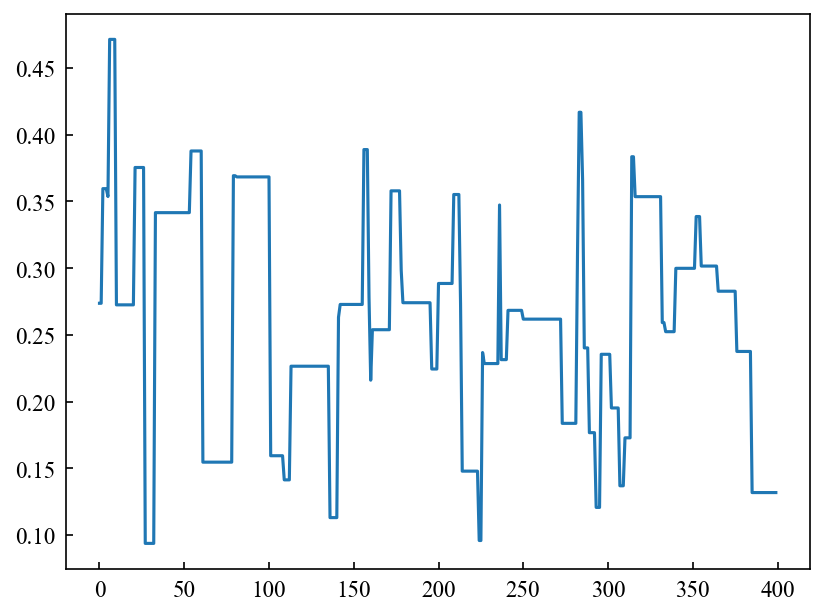

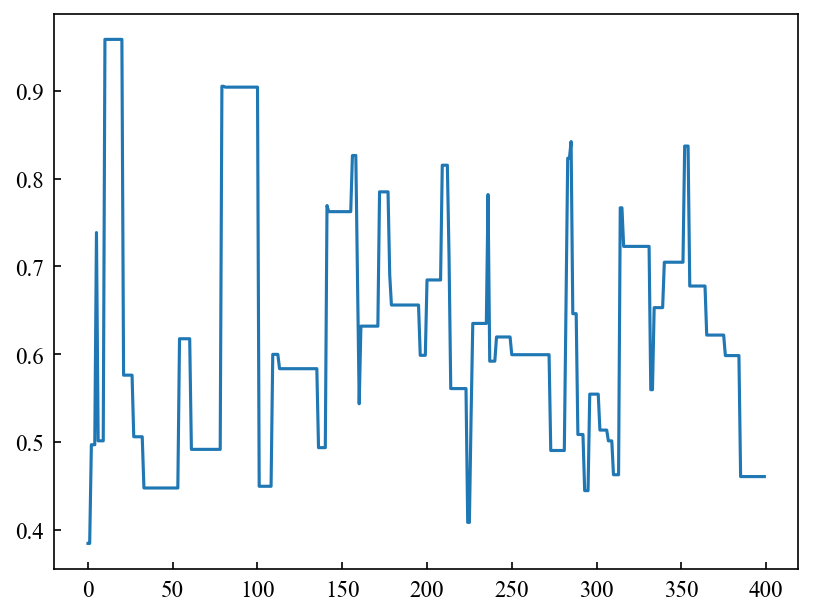

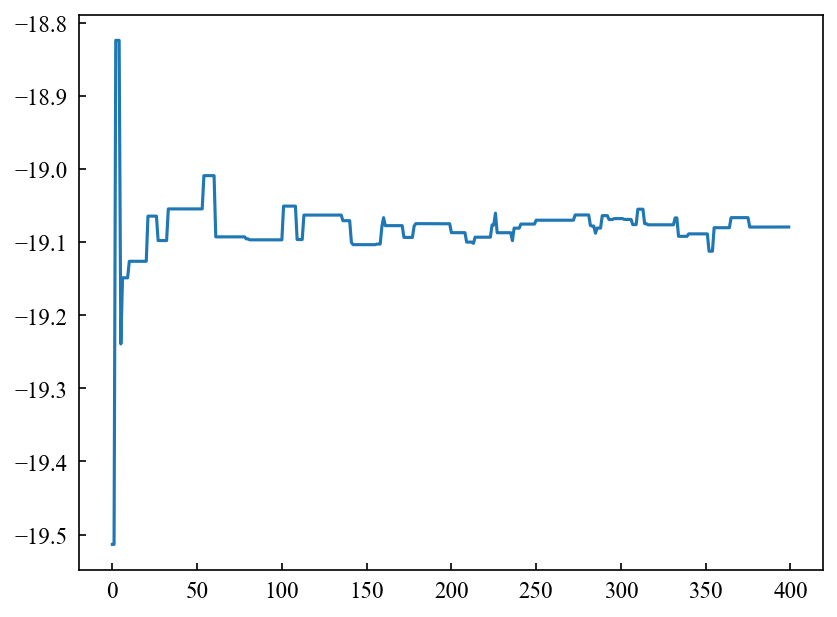

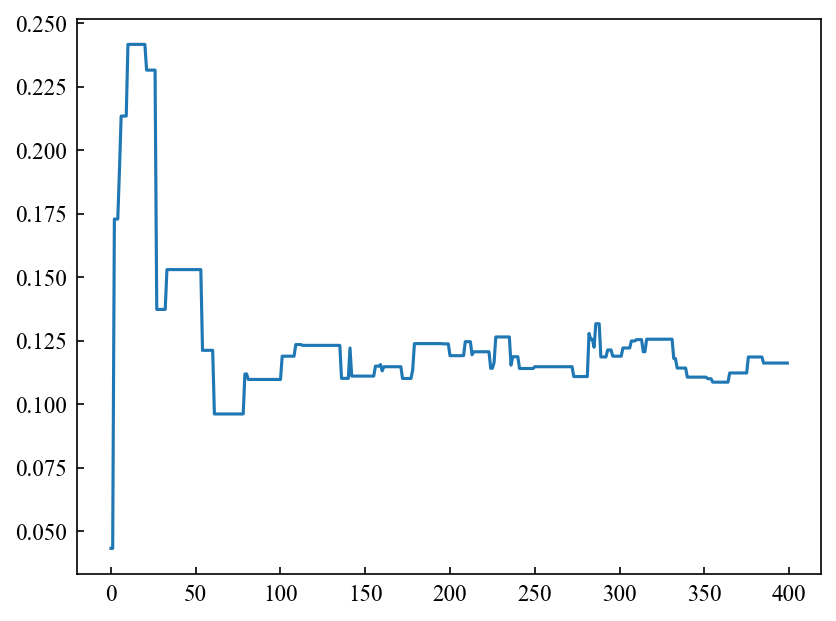

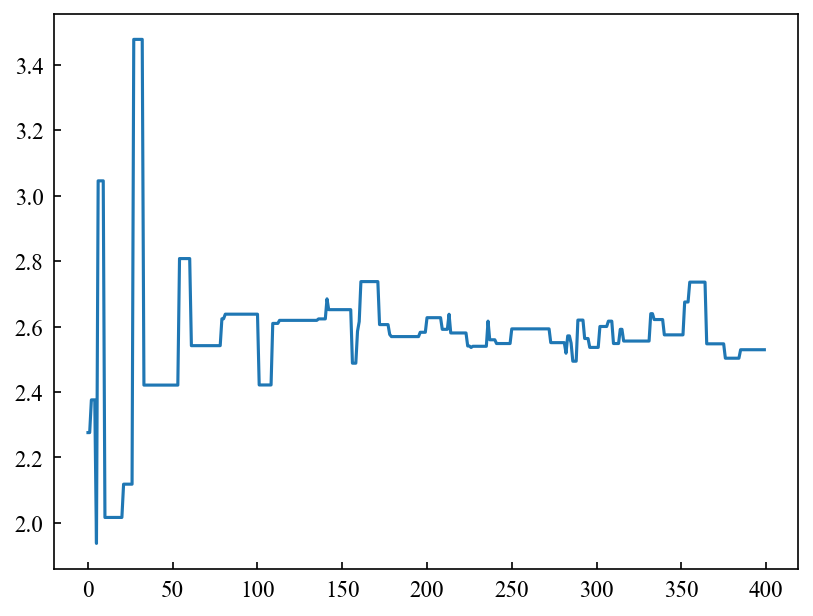

In [40]:
x = [0.2575192, 0.63500065, -19.07998601, 0.11942746, 2.57935686] 
#initialize the walkers near these values to reduce the burn in sequence

nwalkers = 50
nsteps = 10000

om0 = np.random.uniform(x[0]-.2, x[0]+.2, size = nwalkers)
oml = np.random.uniform(x[1]-.2, x[1]+.2, size = nwalkers)
M0 = np.random.uniform(x[2]-1, x[2]+1, size = nwalkers)
a = np.random.uniform(x[3]-.1, x[3]+.1, size = nwalkers)
b = np.random.uniform(x[4]-1, x[4]+1, size = nwalkers)

x0 = np.zeros(shape = (nwalkers, 5))


x0[:,0] += om0 
x0[:,1] += oml 
x0[:,2] += M0 
x0[:,3] += a 
x0[:,4] += b


bounds = [[0, 1], [0, 1], [-25, -15], [0, .3], [0, 5]]

bounds = np.array(bounds)

xnext1, chain1, accept_prob = de_mcmc(x0, logpdf = log_posterior, atol = 1e-6, nsteps = nsteps, bounds = bounds)



o = chain1[0 ,0, 0:400]
l = chain1[0 ,1, 0:400]
M = chain1[0 ,2, 0:400]
a = chain1[0 ,3, 0:400]
b = chain1[0 ,4, 0:400]


plt.plot(o)
plt.show()
plt.plot(l)
plt.show()
plt.plot(M)
plt.show()
plt.plot(a)
plt.show()
plt.plot(b)
plt.show()

#based on our plots the width seems to be around 50 samples. 
# since we have a total of 10000 samples, that means we have around 
#10000 / 50 = 2000 unique samples. 

/var/folders/m0/hlc6y73128n1wbz2yg_t5bh40000gn/T/ipykernel_7297/4239417626.py:95: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(X, Y, H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = sorted(lvls),


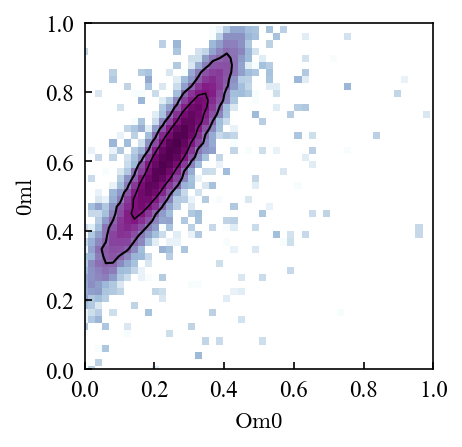

In [42]:
x1 = chain1[:, 0, :].flatten()
y1 = chain1[:, 1, :].flatten()
conflevs = [0.6827, 0.9545]


plot_2d_dist(x1, y1, xlim=[0, 1], ylim =[0, 1], 
             nxbins=50, nybins=50, 
             clevs=conflevs, 
             xlabel=r'${\rm Om0}\ $', 
             ylabel=r'${\rm 0ml}\ $', figsize=(3,3))

In [43]:
chain_stats(x1, param_name='x')
chain_stats(y1, param_name='y')

============ statistics for the x ============
mean, median = 0.254, 0.256, st.dev=0.0737
68 perc interval = 0.181, 0.326
95 perc interval = 0.101, 0.395
============ statistics for the y ============
mean, median = 0.627, 0.631, st.dev=0.1189
68 perc interval = 0.509, 0.746
95 perc interval = 0.378, 0.857


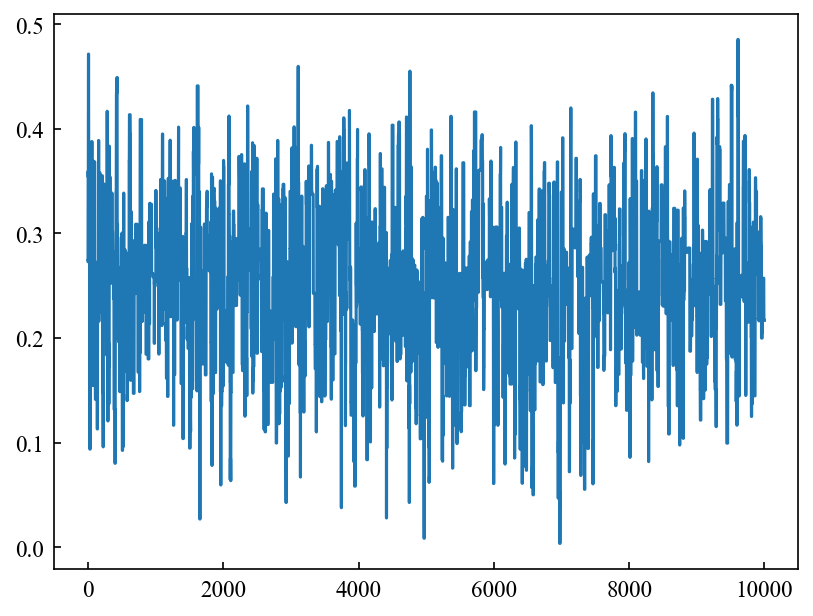

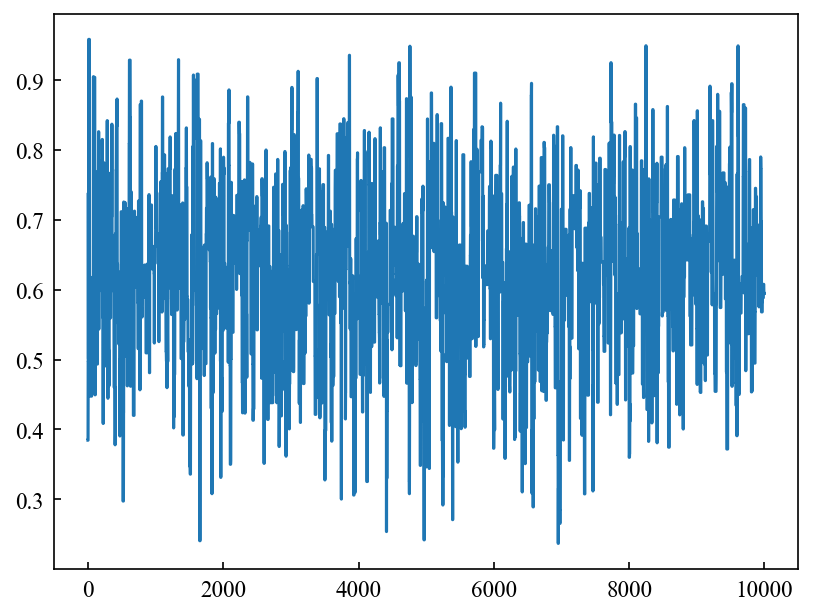

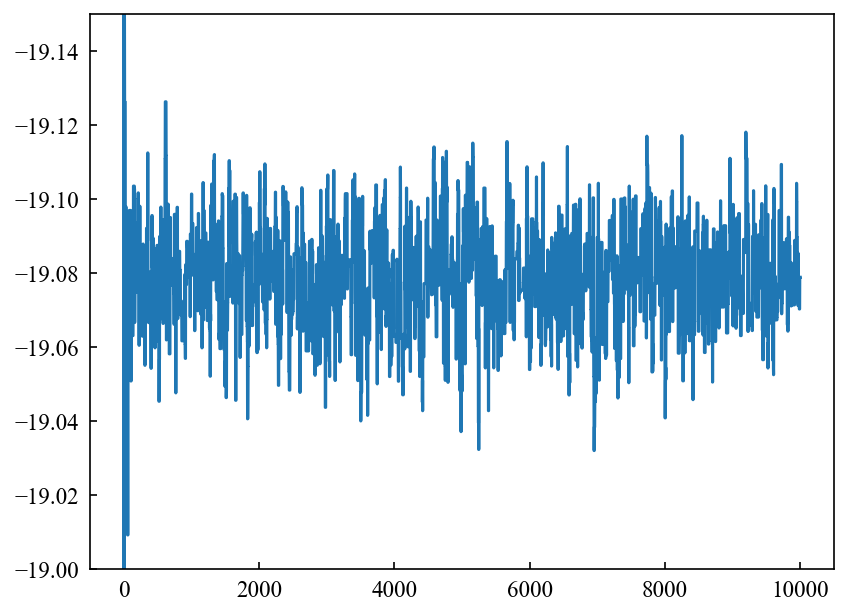

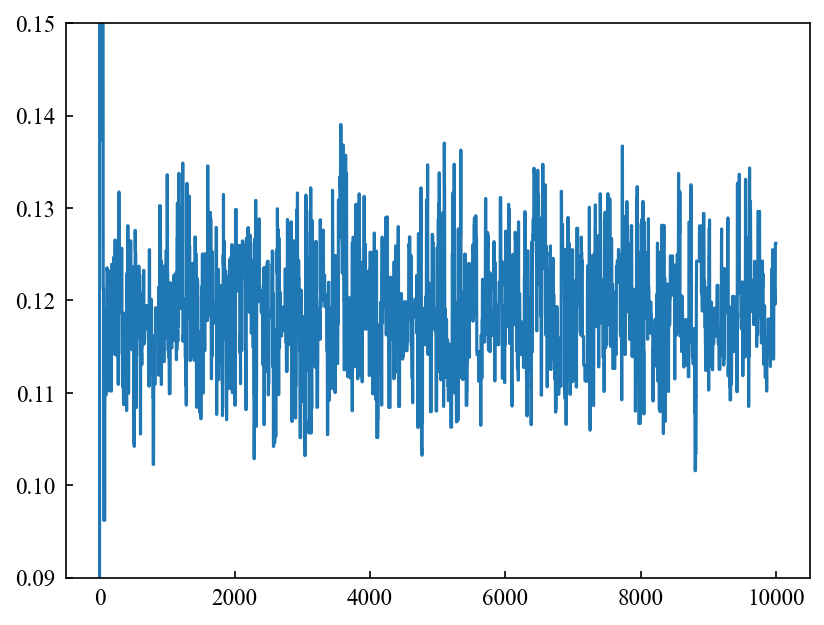

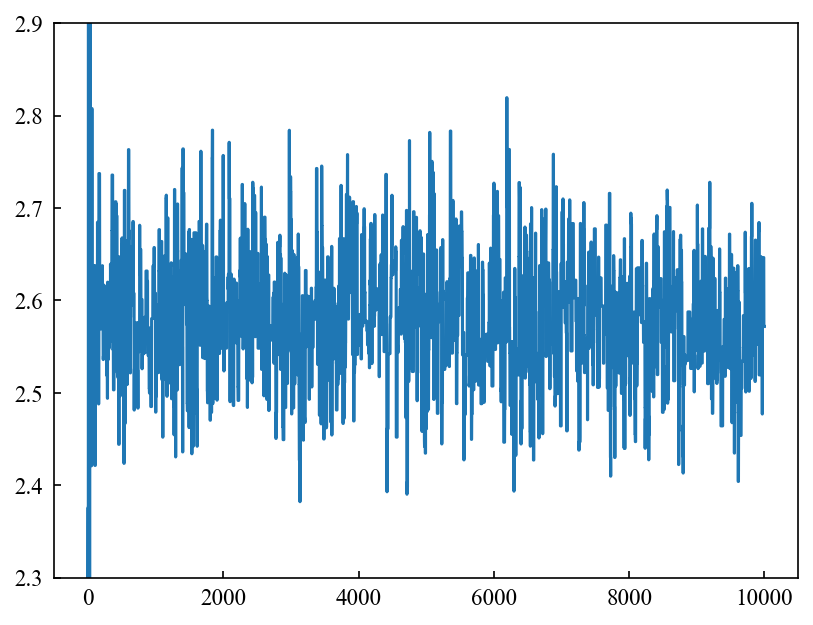

In [46]:
o1 = chain1[0 ,0, :]
l1 = chain1[0 ,1, :]
M1 = chain1[0 ,2, :]
a1 = chain1[0 ,3, :]
b1 = chain1[0 ,4, :]

plt.plot(o1)
plt.show()
plt.plot(l1)
plt.show()
plt.plot(M1)
plt.ylim(-19, -19.15)
plt.show()
plt.plot(a1)
plt.ylim(.090, .150)
plt.show()
plt.plot(b1)
plt.ylim(2.3, 2.9)
plt.show()

#these are the hairy catepillar plots that we want. 
